# Readout integration weights

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

The first step is downsampling the input ADC signals with a list of rectangular windows.

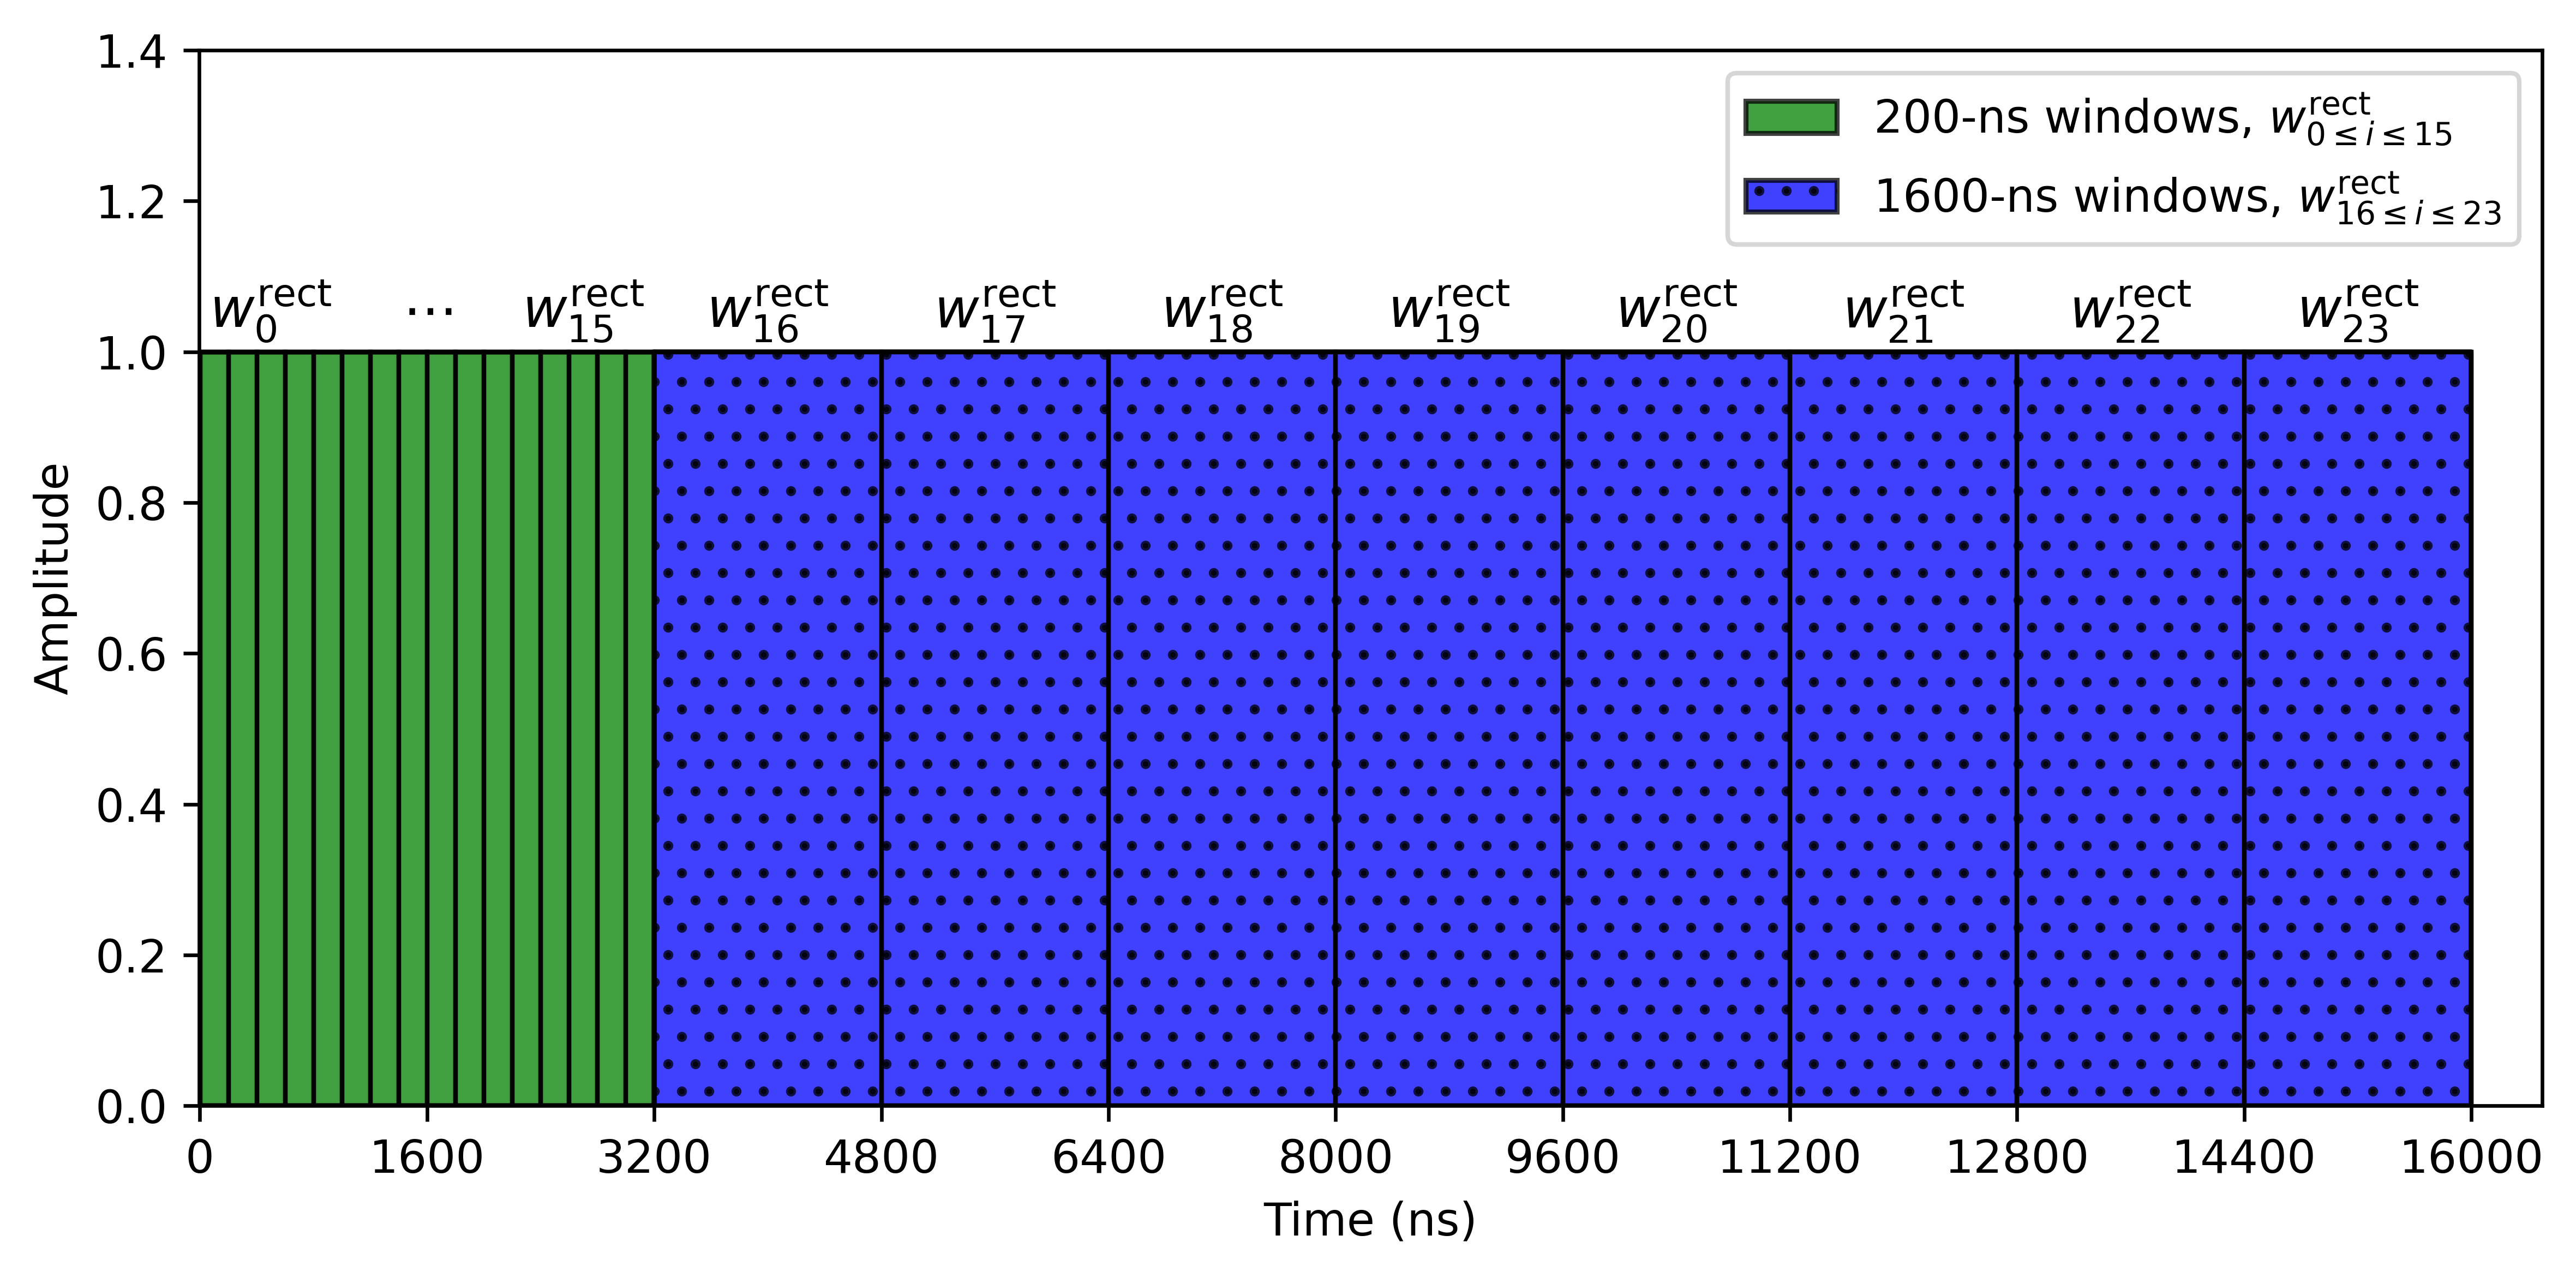

In [118]:
integration_len_ns = 16000

t_ns = np.arange(integration_len_ns)
window_blank = np.zeros(integration_len_ns, dtype=np.float64)

purple = '#6700CC'
orange = '#FFAA00'
gray = '#777777'

fig, ax = plt.subplots(figsize=(8, 4), dpi=600)

windows_200ns = window_blank.copy()
windows_200ns[:3200] = 1.0
ax.fill_between(t_ns, windows_200ns, color='g', label=r'200-ns windows, $w^{\mathrm{rect}}_{0\leq i \leq 15}$', alpha=0.75, edgecolor='k', linewidth=1.1)

windows_1600ns = window_blank.copy()
windows_1600ns[3200:] = 1.0
ax.fill_between(t_ns, windows_1600ns, color='b', label=r'1600-ns windows, $w^{\mathrm{rect}}_{16\leq i \leq 23}$', alpha=0.75, edgecolor='k', linewidth=1.1, hatch='..')

y_labels = 1.032

for i in range(16):
    rect = patches.Rectangle((i*200, 0.0), 200, 1, linewidth=1, edgecolor='k', fill=False)
    ax.add_patch(rect)

for i in range(2, 10):
    rect = patches.Rectangle((i*1600, 0.0), 1600, 1, linewidth=1, edgecolor='k', fill=False)
    ax.add_patch(rect)
    ax.text(i*1600 + 800, y_labels, r'$w^{\mathrm{rect}}_{' + str(i + 14) + r'}$', ha='center', fontsize=12)

ax.text(500, y_labels, r'$w^{\mathrm{rect}}_{0}$', ha='center', fontsize=12)
ax.text(1600, y_labels, r'$\cdots$', ha='center', fontsize=12)
ax.text(2700, y_labels, r'$w^{\mathrm{rect}}_{15}$', ha='center', fontsize=12)

ax.legend()
plt.xticks(np.arange(0, 16001, 1600))
plt.xlim(-4, 16500)
plt.ylim(0, 1.4)
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
fig.tight_layout()
plt.show()

In [119]:
fig.savefig(r"./Figures/integration_weights_windows.png")
fig.savefig(r"./Figures/integration_weights_windows.pdf")

In [ ]:
def calc_weights(IData, QData):
    num_weights = 6
    n_avgs = IData.shape[0]
    len_weights = IData.shape[-1]
    X = np.concatenate([IData, QData], axis=2).reshape((2 * n_avgs, -1))
    y = np.empty((n_avgs, 2))
    y[:, 0] = 0
    y[:, 1] = 1
    y = y.flatten()
    
    clf = LinearDiscriminantAnalysis()

    # The resulting coefficients (clf.coef_[0]) are normalized to create weights_IA
    clf.fit(X, y)
    weights_IA = clf.coef_[0]
    weights_IA /= np.linalg.norm(weights_IA)
    
    # weights_IB is generated as a transformation of weights_IA by reshaping it into a 2D array (weights_IQA) and creating a perpendicular vector.
    weights_IQA = weights_IA.reshape((2, -1))
    weights_IB = np.hstack([-weights_IQA[1], weights_IQA[0]]).flatten()

    # Subtract the contribution of weights_IA from X
    X -= np.einsum('ij,j,k->ik', X, weights_IA, weights_IA)
    
    # Subtract the contribution of weights_IB from X
    X -= np.einsum('ij,j,k->ik', X, weights_IB, weights_IB)
    
    # Refit LDA to calculate weights_IC
    clf.fit(X, y)
    weights_IC = clf.coef_[0]
    weights_IC /= np.linalg.norm(weights_IC)

    weights_IQC = weights_IC.reshape((2, -1))
    weights = np.hstack([-weights_IQC[1], weights_IQC[0]]).flatten()
    
    weights = np.insert(weights, 0, weights_IC, axis=0)
    weights = np.insert(weights, 0, weights_IB, axis=0)
    weights = np.insert(weights, 0, weights_IA, axis=0)
    weights *= np.sqrt(2 * len_weights)
    weights =  weights.reshape(4, 2, -1)
    weights_I = weights[:, 0, :]
    weights_Q = weights[:, 1, :]

    return weights_I, weights_Q

durations = np.array([
    200,  200,  200,  200,  200,  200,  200,  200,  200,  200,  200,  200,
    200,  200,  200,  200, 1600, 1600, 1600, 1600, 1600, 1600, 1600, 1600
], dtype=np.int32)

def plot_weights(weights_I, weights_Q):
    t = 0
    t_list = [0]
    for duration in durations:
        t += duration
        t_list.append(t)

    t_list_complete = np.repeat(t_list, 2)[1: -1]
    
    n = 1
    fig = plt.figure(figsize=(7, 5), dpi=600)
    plt.subplots_adjust(left=0.08, right=0.98, bottom=0.1, top=0.98, wspace=0.25, hspace=0.25)
    ylabels = ['I (a.u.)', 'J (a.u.)', 'K (a.u.)', 'L (a.u.)']
    for weights_I_n, weights_Q_n, ylabel in zip(weights_I, weights_Q, ylabels):
        plt.subplot(2, len(weights_I) // 2, n)
        weights_I_n_complete = np.repeat(weights_I_n, 2)
        weights_Q_n_complete = np.repeat(weights_Q_n, 2)
        plt.plot(t_list_complete, weights_I_n_complete, linestyle='-', label='weights I', color='purple')
        plt.plot(t_list_complete, weights_Q_n_complete, linestyle='--', label='weights Q', color='orange')
        plt.xticks(np.arange(0, 16001, 3200))
        plt.legend()
        plt.xlabel('Time (ns)')
        plt.ylabel(ylabel)
        n += 1
    plt.tight_layout
    plt.show()
    return fig

In [121]:
ADC_sample_file = r'./Data/ADC_sample.hdf5'
with h5py.File(ADC_sample_file, 'r') as hf:
    IData_sample = np.array(hf['IData_sample'][:])
    QData_sample = np.array(hf['QData_sample'][:])

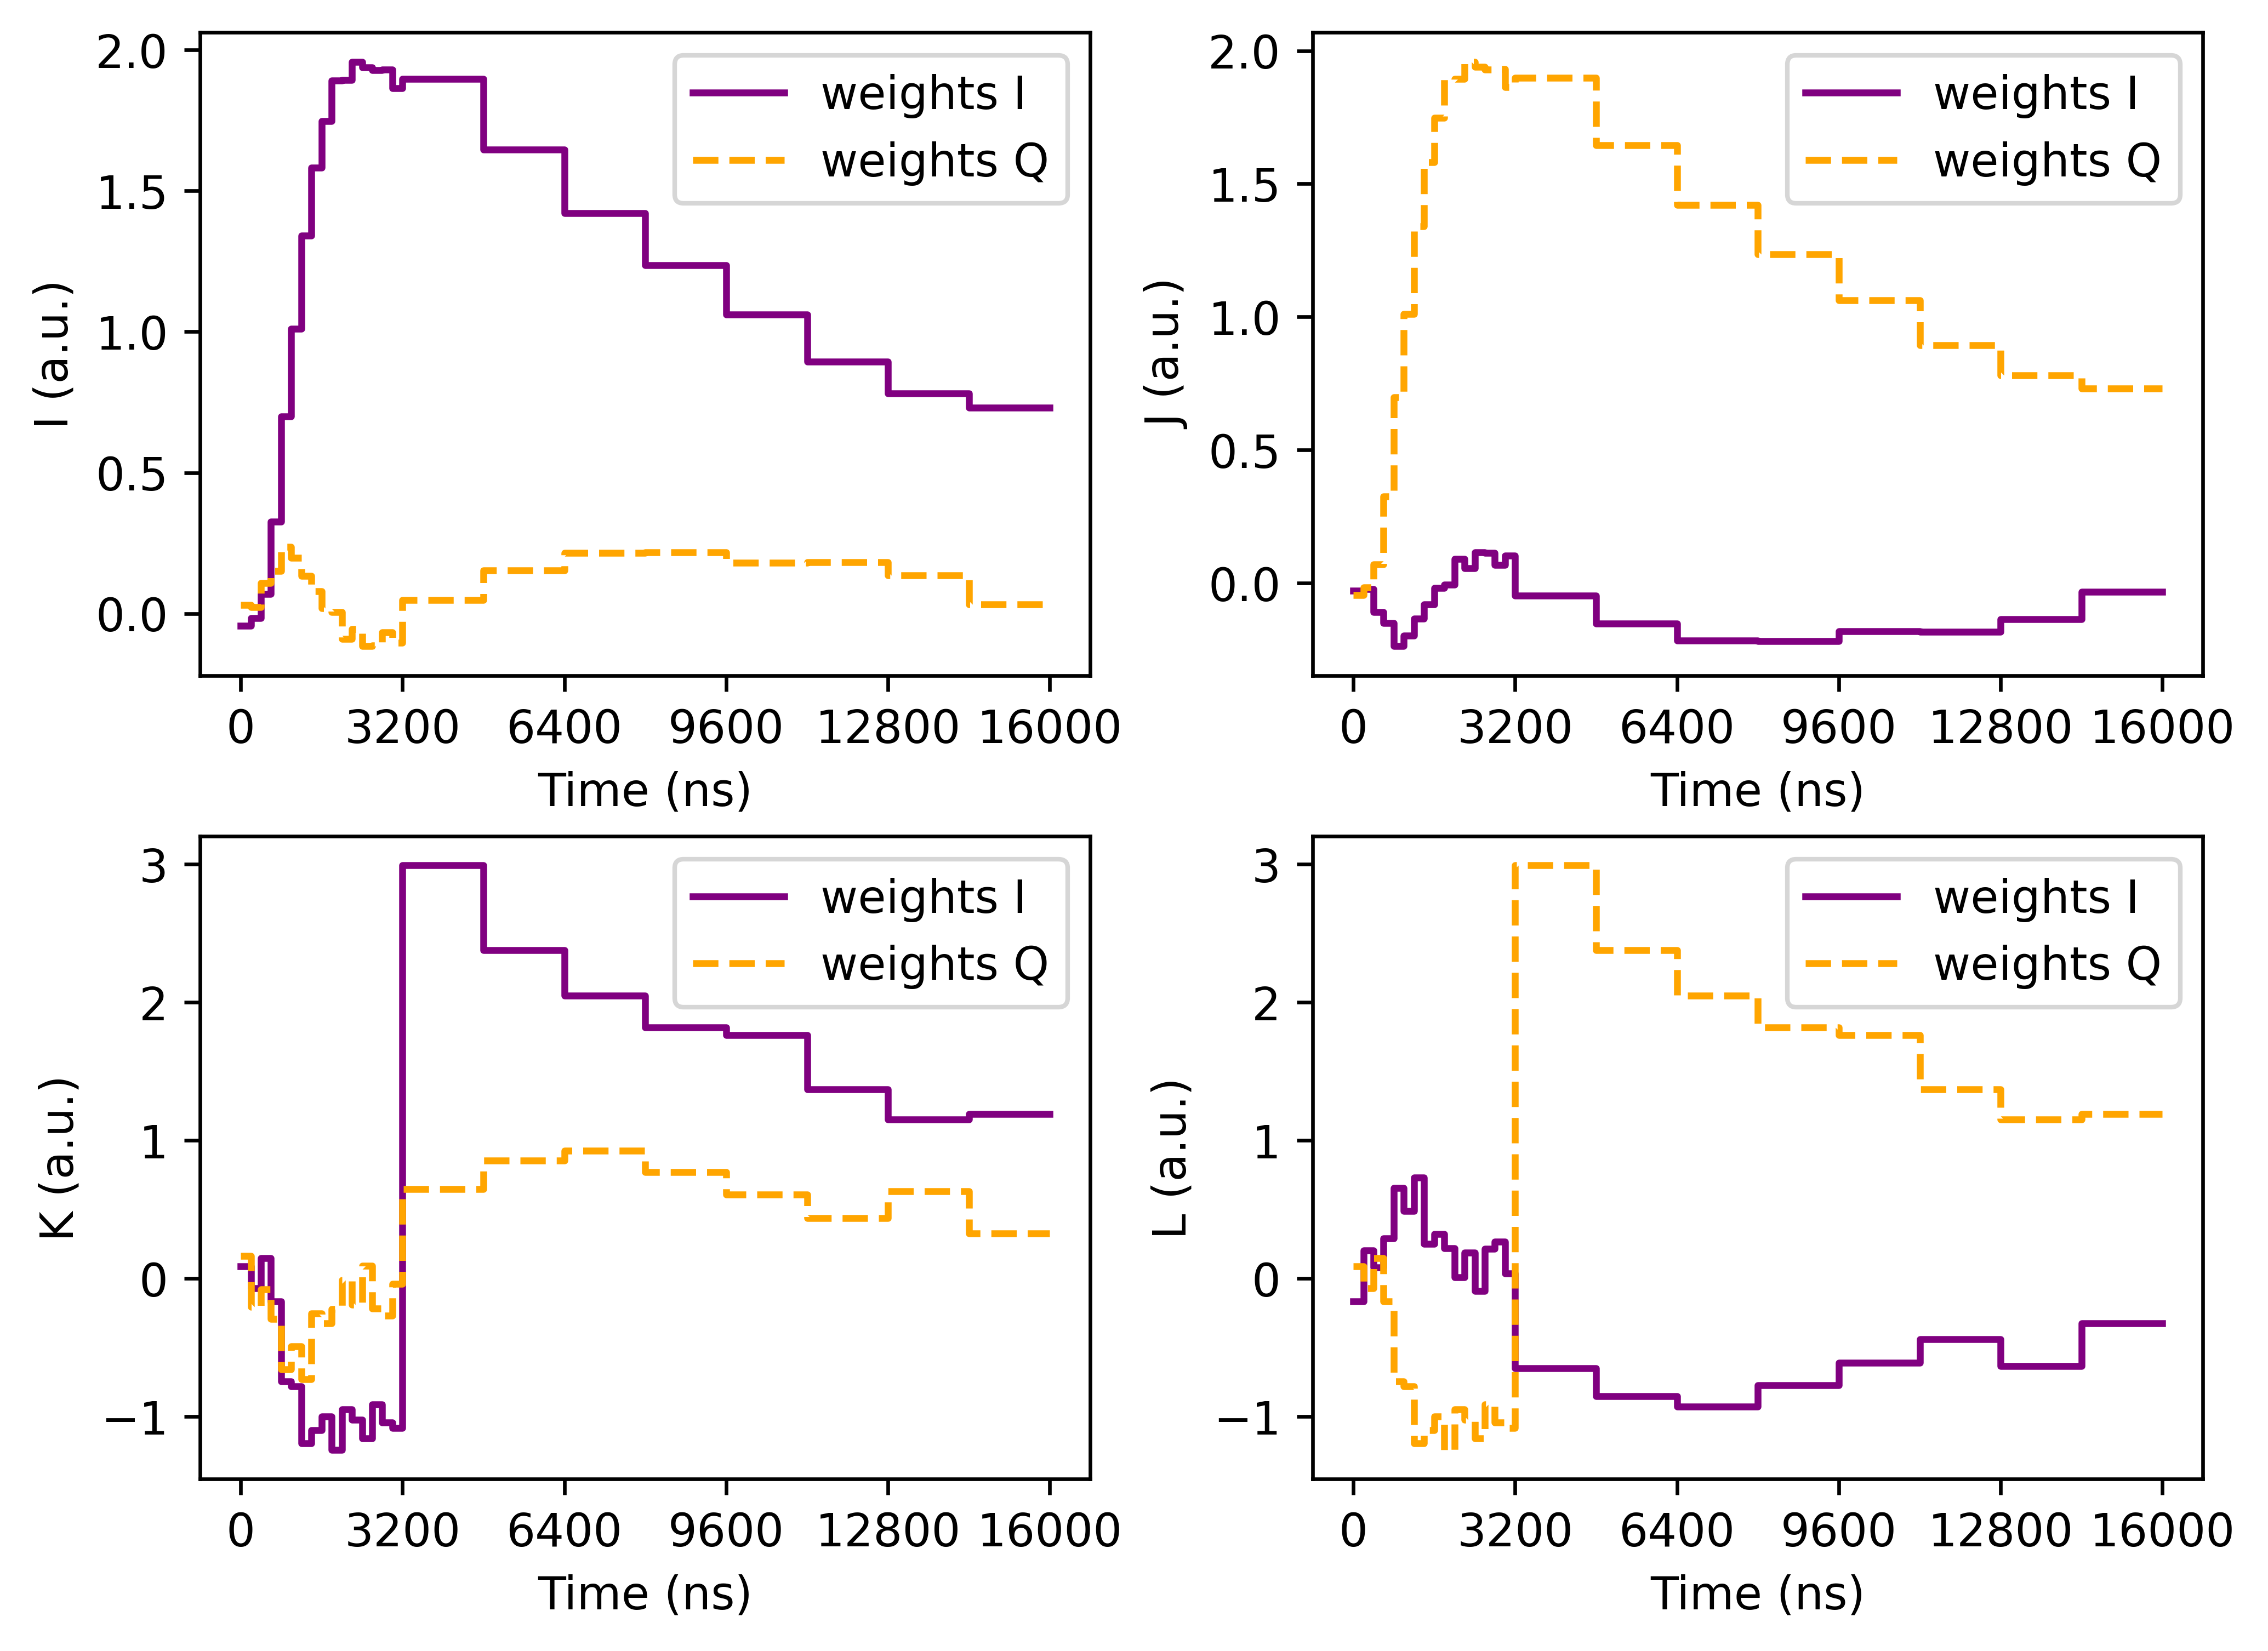

In [122]:
res_1_iw_I_new, res_1_iw_Q_new = calc_weights(IData_sample, QData_sample)
fig = plot_weights(res_1_iw_I_new, res_1_iw_Q_new)

In [123]:
fig.savefig(r"./Figures/integration_weights.png")